In [4]:
# arrays
import numpy as np

# unpacking files 
import tarfile

# fits
from astropy.io import fits
from astropy.utils.data import download_file

# plotting
import matplotlib.pyplot as plt
from matplotlib import ticker

# stella CNN functions
import stella

# keras
from keras.models import Sequential, Model, load_model
from keras.layers import Input, Flatten, Dense, Activation, Dropout, BatchNormalization
from keras.layers.convolutional import Convolution1D, MaxPooling1D

# sklearn for performance metrics
from sklearn import metrics

# lightkurve
from lightkurve.search import search_lightcurve

# from IPython import get_ipython
# get_ipython().run_line_magic('matplotlib', 'notebook')

# set random seed for reproducibility 
np.random.seed(42)

# Exercise 1: better performance with a better model

We'll take the same steps as in the other notebook, but with less narrative in between.

In [5]:
file_url = 'https://archive.stsci.edu/hlsps/hellouniverse/hellouniverse_stella_500.tar.gz'


file = tarfile.open(download_file(file_url, cache=True))


file.extractall('.')
file.close() # be sure to close files when you're finished with them!

data_dir = './hellouniverse_stella_500/'
ds = stella.FlareDataSet(fn_dir=data_dir,
                         catalog=data_dir+'Guenther_2020_flare_catalog.txt')

Reading in training set files.


100%|██████████| 62/62 [00:00<00:00, 469.93it/s]

502 positive classes (flare)
1342 negative classes (no flare)
37.0% class imbalance



In [6]:
# remove lightcurves with NaNs from training, test and validation data
def remove_nans(input_data):
    '''Determine indices of files without NaNs'''

    idx = []
    for k in range(np.shape(input_data)[0]):
        if len(input_data[k, :, :][np.isnan(input_data[k, :, :])]) == 0:
            idx.append(k)
    # AS: how do we want to talk about functions? assume that people know how they work for the intermediate notebooks?
    return idx


# find indices in train, test and validation sets without NaNs
idx_train = remove_nans(ds.train_data)
idx_test = remove_nans(ds.test_data)
idx_val = remove_nans(ds.val_data)

ds.train_data = ds.train_data[idx_train]
ds.train_labels = ds.train_labels[idx_train]

ds.test_data = ds.test_data[idx_test]
ds.test_labels = ds.test_labels[idx_test]

ds.val_data = ds.val_data[idx_val]
ds.val_labels = ds.val_labels[idx_val]

In [7]:
# set the random seed
seed = 42
np.random.seed(seed)

dense = 128

filter1 = 16
filter2 = 64

# ok, let's do a real hyperparameter optimization.

dense = 128

dropout = 0.1 # let's keep this low for now.

data_shape = np.shape(ds.train_data)
input_shape = (np.shape(ds.train_data)[1], 1)

# set up the network
x_in = Input(shape=input_shape)
c0 = Convolution1D(7, filter1, activation='relu', padding='same', input_shape=input_shape)(x_in)
b0 = MaxPooling1D(pool_size=2)(c0)
d0 = Dropout(dropout)(b0)

c1 = Convolution1D(3, filter2, activation='relu', padding='same')(d0)
b1 = MaxPooling1D(pool_size=2)(c1)
d1 = Dropout(dropout)(b1)


f = Flatten()(d1)
z0 = Dense(dense, activation='relu')(f)
d2 = Dropout(dropout)(z0)
y_out = Dense(1, activation='sigmoid')(d2)


# instantiate the network
cnn = Model(inputs=x_in, outputs=y_out)

# Compile Model
optimizer = 'adam'
fit_metrics = ['accuracy'] 
loss = 'binary_crossentropy'
cnn.compile(loss=loss, optimizer=optimizer, metrics=fit_metrics)
cnn.summary()


nb_epoch = 500 # the model sees the dataset 100 times
batch_size = 64 # 64 light curves are seen before the model updates itself

# between each epoch, present the data in a different order. This can help prevent overfitting or order bias.
shuffle = True 

# Train
history = cnn.fit(ds.train_data, ds.train_labels,
                  batch_size=batch_size, 
                  epochs=nb_epoch, 
                  validation_data=(ds.val_data, ds.val_labels), 
                  shuffle=shuffle,
                  verbose=False) # we lower the verbosity — because that's a lot of epochs to priont!

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 200, 7)            119       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 100, 7)           0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 100, 7)            0         
                                                                 
 conv1d_1 (Conv1D)           (None, 100, 3)            1347      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 50, 3)            0         
 1D)                                                         

In [8]:
def plot_confusion_matrix(cnn, input_data, input_labels):
    
    # Compute flare predictions for the test dataset
    predictions = cnn.predict(input_data)

    # Convert to binary classification 
    predictions = (predictions > 0.5).astype('int32') 
    
    # Compute the confusion matrix by comparing the test labels (ds.test_labels) with the test predictions
    cm = metrics.confusion_matrix(input_labels, predictions, labels=[0, 1])
    cm = cm.astype('float')

    # Normalize the confusion matrix results. 
    cm_norm = cm / cm.sum(axis=1)[:, np.newaxis]
    
    # Plotting
    fig = plt.figure()
    ax = fig.add_subplot(111)

    ax.matshow(cm_norm, cmap='binary_r')

    plt.title('Confusion matrix', y=1.08)
    
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['Flare', 'No Flare'])
    
    ax.set_yticks([0, 1])
    ax.set_yticklabels(['Flare', 'No Flare'])

    plt.xlabel('Predicted')
    plt.ylabel('True')

    fmt = '.2f'
    thresh = cm_norm.max() / 2.
    for i in range(cm_norm.shape[0]):
        for j in range(cm_norm.shape[1]):
            ax.text(j, i, format(cm_norm[i, j], fmt), 
                    ha="center", va="center",color="white" if cm_norm[i, j] < thresh else "black")
    plt.show()

6/6 [==============================] - 0s 3ms/step


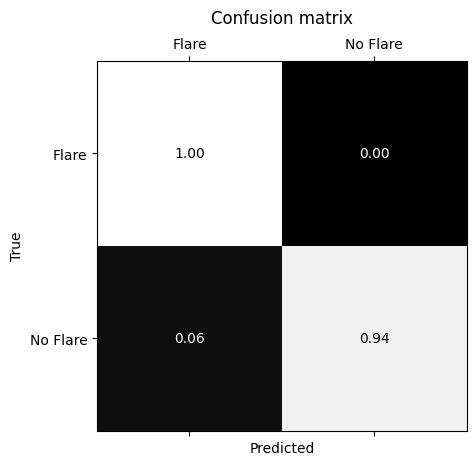

In [ ]:
plot_confusion_matrix(cnn, ds.test_data, ds.test_labels)


In [ ]:
# need to check the validation and loss

Text(0, 0.5, 'Loss')

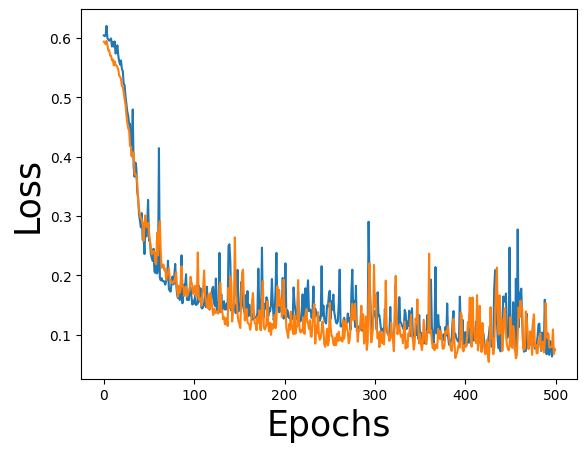

In [ ]:
plt.plot(history.history['val_loss'])
plt.plot(history.history['loss'])

plt.xlabel('Epochs', fontsize=25)
plt.ylabel('Loss', fontsize=25)

Text(0, 0.5, 'Accuracy')

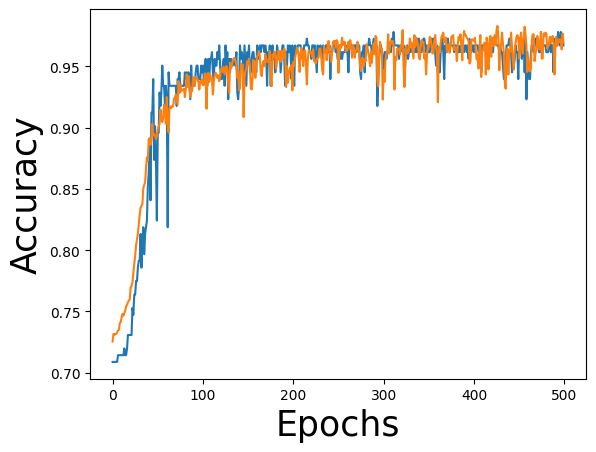

In [ ]:
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['accuracy'])

plt.xlabel('Epochs', fontsize=25)
plt.ylabel('Accuracy', fontsize=25)

It seems like the validation and training loss are beginning to plateau. However, we haven't entered a particularly nasty regime yet — i.e., the validation loss hasn't begun to *increase*. So, it seems like there's still some room for more training even with just this dataset.

# Exercise 2: better performance with more data

Do note that using *this much more data* can take quite some time to download.

In [ ]:
# take 2: more data. we'll use the download_catalog function from the stella documentation.
download = stella.DownloadSets(fn_dir='.')
download.download_catalog()
download.flare_table = download.flare_table[0:4000]
download.download_lightcurves()
ds = stella.FlareDataSet(downloadSet=download)

  6%|▌         | 35/587 [01:24<1:19:11,  8.61s/it]

In [ ]:
ds = stella.FlareDataSet(fn_dir='.',
                         catalog='./'+'Guenther_2020_flare_catalog.txt')

In [ ]:
# set the random seed
seed = 42
np.random.seed(seed)

dense = 128

filter1 = 16
filter2 = 64

# ok, let's do a real hyperparameter optimization.

dense = 128

dropout = 0.1 # let's keep this low for now.

data_shape = np.shape(ds.train_data)
input_shape = (np.shape(ds.train_data)[1], 1)

# set up the network
x_in = Input(shape=input_shape)
c0 = Convolution1D(7, filter1, activation='relu', padding='same', input_shape=input_shape)(x_in)
b0 = MaxPooling1D(pool_size=2)(c0)
d0 = Dropout(dropout)(b0)

c1 = Convolution1D(3, filter2, activation='relu', padding='same')(d0)
b1 = MaxPooling1D(pool_size=2)(c1)
d1 = Dropout(dropout)(b1)


f = Flatten()(d1)
z0 = Dense(dense, activation='relu')(f)
d2 = Dropout(dropout)(z0)
y_out = Dense(1, activation='sigmoid')(d2)


# instantiate the network
cnn = Model(inputs=x_in, outputs=y_out)

# Compile Model
optimizer = 'adam'
fit_metrics = ['accuracy'] 
loss = 'binary_crossentropy'
cnn.compile(loss=loss, optimizer=optimizer, metrics=fit_metrics)
cnn.summary()


nb_epoch = 500 # the model sees the dataset 100 times
batch_size = 64 # 64 light curves are seen before the model updates itself

# between each epoch, present the data in a different order. This can help prevent overfitting or order bias.
shuffle = True 

# Train
history = cnn.fit(ds.train_data, ds.train_labels,
                  batch_size=batch_size, 
                  epochs=nb_epoch, 
                  validation_data=(ds.val_data, ds.val_labels), 
                  shuffle=shuffle,
                  verbose=False) # we lower the verbosity — because that's a lot of epochs to priont!

In [ ]:
plot_confusion_matrix(cnn, ds.test_data, ds.test_labels)


In [ ]:
plt.plot(history.history['val_loss'])
plt.plot(history.history['loss'])

plt.xlabel('Epochs', fontsize=25)
plt.ylabel('Loss', fontsize=25)

In [ ]:
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['accuracy'])

plt.xlabel('Epochs', fontsize=25)
plt.ylabel('Accuracy', fontsize=25)